In [2]:
! pip install torch_geometric

20.61s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [193]:
import torch
import numpy as np
from torch_geometric.data import Data
from torch_geometric.utils import degree
import cv2
import matplotlib.pyplot as plt
mask_graph = cv2.imread('/home/admina/segmetation/DLOSeg/outputs/grounded_sam2_local_demo/groundingdino_mask_0.png', cv2.IMREAD_GRAYSCALE)
height, width = mask_graph.shape
# optoinaly use blure 
# blurred = cv2.GaussianBlur(mask_graph, (3, 3), sigmaX=1.0)
# Downsample to half size with high-quality interpolation

"""
Downsampling with OpenCV (`cv2.resize`):

OpenCV provides several interpolation methods for resizing images. When downsampling,
choosing the right interpolation is key to preserving image quality.

Interpolation options:

- cv2.INTER_NEAREST: Nearest-neighbor interpolation
    * Very fast, but produces blocky results
    * Not recommended for quality-sensitive tasks

- cv2.INTER_LINEAR: Bilinear interpolation (default for upsampling)
    * Reasonably fast and smoother than nearest
    * Good for general use

- cv2.INTER_AREA: Resampling using pixel area relation
    * **Best for downsampling**
    * Reduces aliasing by averaging pixel values

- cv2.INTER_CUBIC: Bicubic interpolation over 4x4 pixel neighborhoods
    * Higher quality than linear, slower

- cv2.INTER_LANCZOS4: Lanczos interpolation over an 8x8 pixel neighborhood
    * **Best quality for downsampling**
    * Computationally expensive

Recommended for downsampling:
    - Use `cv2.INTER_AREA` for a balance between quality and speed
    - Use `cv2.INTER_LANCZOS4` when highest quality is needed

Optional anti-aliasing tip:
    - Apply a slight Gaussian blur before downsampling to further reduce aliasing artifacts
"""
# allwase H,W
mask = cv2.resize(mask_graph, (width // 2, height // 2), interpolation=cv2.INTER_AREA)
mask = (mask > 0).astype(np.uint8)  # Convert to binary mask
hight, width = mask.shape

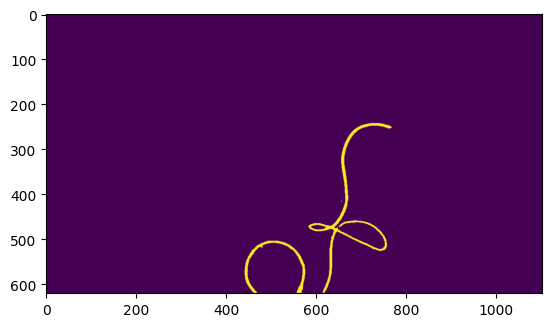

(621, 1104)


In [194]:
# mask_graph = cv2.ximgproc.thinning(mask_graph.astype(np.uint8), thinningType=cv2.ximgproc.THINNING_ZHANGSUEN)

plt.imshow(mask)
plt.show()


print(mask.shape)

In [ ]:
# on image the x is the row from left to right and y is the column from top to bottom
# and shape[0] is the y and shape[1] is the x
mask_graph.shape

# so in order to go to a graph we need the y to be hight - y 

(621, 1104)

Graph creation time: 0.1084 seconds


In [ ]:
# Convert skeleton mask to graph
mask_graph = (mask_graph > 0).astype(np.uint8)
nodes = np.argwhere(mask_graph == 1)
node_indices = {tuple(node): idx for idx, node in enumerate(nodes)}

edge_list = []
directions = [(-1, -1), (-1, 0), (-1, 1),
              (0, -1),          (0, 1),
              (1, -1),  (1, 0), (1, 1)]

for y, x in nodes:
    for dy, dx in directions:
        ny, nx = y + dy, x + dx
        if 0 <= ny < mask_graph.shape[0] and 0 <= nx < mask_graph.shape[1]:
            if mask_graph[ny, nx]:
                edge_list.append([node_indices[(y, x)], node_indices[(ny, nx)]])



In [53]:
from scipy.sparse import coo_matrix

def binary_mask_to_graph_fast(mask, connectivity=4):
    assert connectivity in (4, 8), "Connectivity must be 4 or 8"
    mask = np.asarray(mask, dtype=bool)
    rows, cols = np.nonzero(mask)
    node_indices = {(r, c): i for i, (r, c) in enumerate(zip(rows, cols))}
    
    # Directions based on connectivity
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)] if connectivity == 4 else [
        (-1, -1), (-1, 0), (-1, 1),
        (0, -1),          (0, 1),
        (1, -1),  (1, 0), (1, 1)
    ]
    
    edge_set = set()
    for dr, dc in directions:
        neighbor_rows, neighbor_cols = rows + dr, cols + dc
        valid = (
            (neighbor_rows >= 0) & (neighbor_rows < mask.shape[0]) &
            (neighbor_cols >= 0) & (neighbor_cols < mask.shape[1]) &
            mask[neighbor_rows, neighbor_cols]
        )
        
        for idx, is_valid in enumerate(valid):
            if is_valid:
                node_a = node_indices[(rows[idx], cols[idx])]
                node_b = node_indices[(neighbor_rows[idx], neighbor_cols[idx])]
                if node_a < node_b:  # avoid duplicates
                    edge_set.add((node_a, node_b))
                else:
                    edge_set.add((node_b, node_a))

    G = nx.Graph()
    G.add_nodes_from(range(len(rows)))
    G.add_edges_from(edge_set)
    
    return G

In [ ]:

nodes = zip(*np.nonzero(mask))
for y,x in  nodes:
    print(y,x)

In [206]:
import networkx as nx
def binary_mask_to_graph(mask, connectivity=4):
    """
    Converts a binary mask into a graph using given connectivity.

    Parameters:
        mask (np.ndarray): 2D binary mask (dtype=bool or 0/1)
        connectivity (int): 4 or 8 (pixel connectivity)

    Returns:
        G (networkx.Graph): Graph with pixel (row, col) as nodes
    """
    assert connectivity in (4, 8), "Connectivity must be 4 or 8"
    
    hight, width = mask.shape
    mask = np.asarray(mask).astype(bool)

    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)] if connectivity == 4 else \
                 [(-1, -1), (-1, 0), (-1, 1),
                  (0, -1),          (0, 1),
                  (1, -1),  (1, 0), (1, 1)]

    nodes = zip(*np.nonzero(mask))
    # node_indices = {node: idx for idx, node in enumerate(nodes)}

    G = nx.Graph()
    G.add_nodes_from(nodes)

    edge_list = []

    # for y, x in nodes:
    #     for dy, dx in directions:
    #         ny, nx_ = y + dy, x + dx
    #         if 0 <= ny < hight and 0 <= nx_ < width:
    #             if mask[ny, nx_]:
    #                 edge_list.append([(y, x), (ny, nx_)])
    for y,x in nodes:
        # if y == 0 or y == hight-1 or x == 0 or x == width-1:
        #     continue
        # Check the 3x3 neighborhood
        view = mask[y-1:y+2, x-1:x+2]
        neoghbors = np.argwhere(view)
        for neighbor in neoghbors:
            ny, nx_ = neighbor
            ny += y - 1
            nx_ += x - 1
            if 0 <= ny < hight and 0 <= nx_ < width:
                if mask[ny, nx_]:
                    edge_list.append([(y, x), (ny, nx_)])
    G.add_edges_from(edge_list)

    return G
G = binary_mask_to_graph(mask, connectivity=8)


In [ ]:


# for ende in G.edges():
#     x , y = ende
#     print(x, y)

In [ ]:
# nodes = np.asarray(G.nodes())
# nodes[:,0]                    y = hight - y


array([244, 244, 244, ..., 620, 620, 620])

In [204]:
edges = np.asarray(G.edges())
edges.shape


(0,)

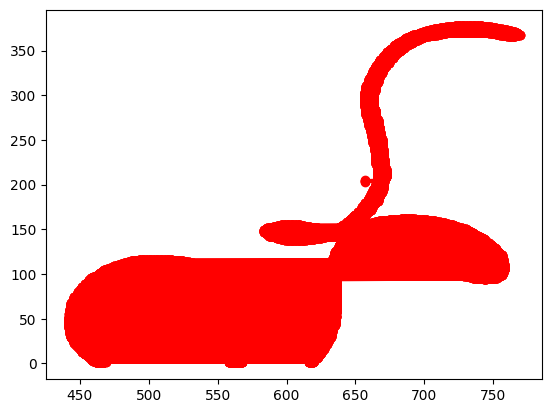

In [158]:
plt.plot(edges[:,:,1], hight - edges[:,:,0], 'ro-')

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

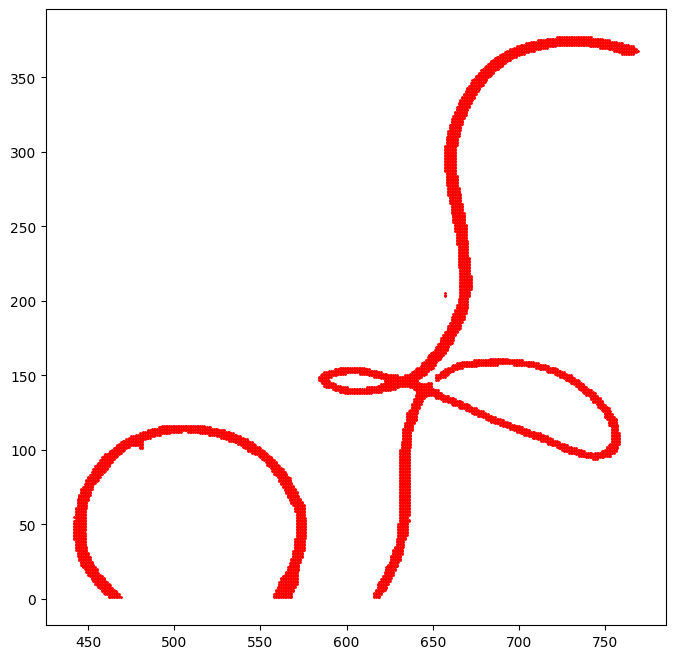

In [189]:
import matplotlib.pyplot as plt
# Function to draw the graph
def draw_nx_graph(graph, img_size=(621, 1104)):
    
    # img = np.zeros(img_size, dtype=np.uint8)
    plt.figure(figsize=(8, 8))
    # pos = {(y, x): idx  for idx, (y, x) in enumerate(graph.nodes())}  # Flip y-axis for correct visual orientation

    # for edge in edge_index.t().cpu().numpy():
    # for edge in graph.edges():
    #     # src, dst = edge
    #     y_coords, x_coords = edge
    #     # x_coords, y_coords = zip(pos[src], pos[dst])
    #     plt.plot(list(x_coords), list(y_coords), color='blue')
    nodes = np.asarray(graph.nodes())
    plt.scatter(nodes[:,1],img_size[0] - nodes[:,0],s=1, c='red')
    edges = np.asarray(graph.edges())
    
    plt.plot(edges[::500,:,1],img_size[0] - edges[::500,:,0], color='blue')
    # plt.axis('equal')
    # plt.axis('off')
    plt.show()
    
draw_nx_graph(G)

In [26]:
edge_list

[]

In [ ]:

# # Your provided skeleton mask
# graph = np.array([[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
#                   [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
#                   [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
#                   [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
#                   [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
#                   [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
#                   [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
#                   [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
#                   [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
#                   [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
#                   [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
#                   [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
#                   [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
#                   [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
#                   [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])


tensor([[    0,     0,     0,  ..., 22911, 22911, 22911],
        [    1,    34,    35,  ..., 22868, 22869, 22910]], device='cuda:0')

Time taken for simplification: 0.024459123611450195


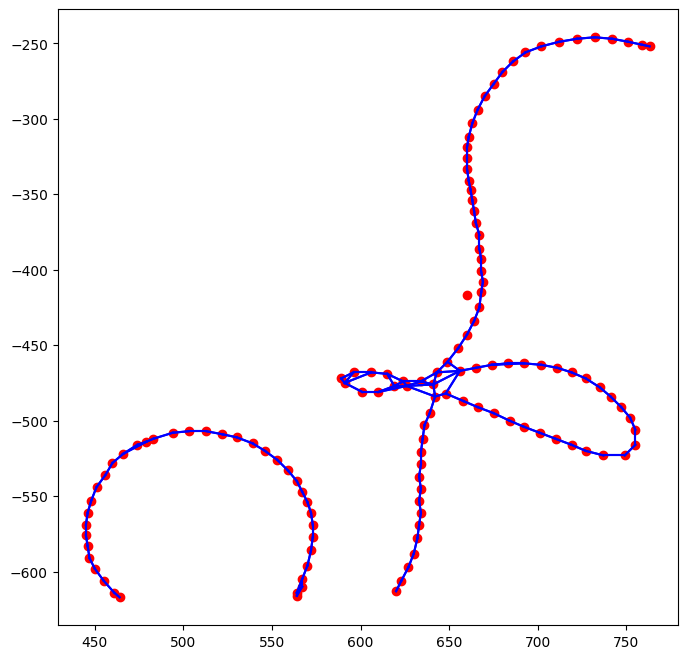

In [110]:
from scipy.spatial.distance import cdist
from scipy.spatial import cKDTree
import time
def simplify_intersections_fast(nodes, edge_index, threshold=1.0):
    # Build KD-tree for fast radius search
    tree = cKDTree(nodes)
    
    n = len(nodes)
    visited = np.zeros(n, dtype=bool)
    clusters = []
    
    for i in range(n):
        if visited[i]:
            continue
        # Find neighbors within threshold
        cluster = tree.query_ball_point(nodes[i], threshold)
        cluster = set(cluster)
        clusters.append(cluster)
        for idx in cluster:
            visited[idx] = True

    # Generate new nodes (averaged cluster centers)
    new_nodes = []
    node_mapping = {}
    for new_idx, cluster in enumerate(clusters):
        cluster = list(cluster)
        mean_pos = np.round(nodes[cluster].mean(axis=0)).astype(int)
        new_nodes.append(mean_pos)
        for old_idx in cluster:
            node_mapping[old_idx] = new_idx

    new_nodes = np.array(new_nodes)

    # Remap edges
    edge_array = edge_index.cpu().numpy().T
    new_edges = {
        (node_mapping[src], node_mapping[dst])
        for src, dst in edge_array
        if node_mapping[src] != node_mapping[dst]
    }

    new_edge_index = torch.tensor(list(new_edges), dtype=torch.long).t()
    
    return new_nodes, new_edge_index

def simplify_intersections(nodes, edge_index, threshold=1.0):
    # Compute pairwise distances between nodes
    distances = cdist(nodes, nodes)
    np.fill_diagonal(distances, np.inf)  # Ignore self-distances

    # Find clusters (nodes closer than threshold)
    clusters = []
    visited = set()
    
    for idx in range(len(nodes)):
        if idx in visited:
            continue
        cluster = set(np.where(distances[idx] <= threshold)[0])
        cluster.add(idx)
        visited.update(cluster)
        clusters.append(cluster)

    # Map old node indices to new node indices
    new_nodes = []
    node_mapping = {}
    for new_idx, cluster in enumerate(clusters):
        cluster_nodes = nodes[list(cluster)]
        representative = np.round(cluster_nodes.mean(axis=0)).astype(int)
        new_nodes.append(representative)
        for old_idx in cluster:
            node_mapping[old_idx] = new_idx

    new_nodes = np.array(new_nodes)

    # Remap edges
    new_edges = set()
    for edge in edge_index.cpu().numpy().T:
        src, dst = node_mapping[edge[0]], node_mapping[edge[1]]
        if src != dst:
            new_edges.add((src, dst))

    new_edge_index = torch.tensor(list(new_edges), dtype=torch.long).t().contiguous()

    return new_nodes, new_edge_index
start = time.time()
# Apply simplification to your graph
simplified_nodes, simplified_edge_index = simplify_intersections_fast(nodes, edge_index, threshold=9.0)
print("Time taken for simplification:", time.time() - start)
# Draw simplified graph
draw_graph(simplified_nodes, simplified_edge_index)


In [109]:
start = time.time()
# Create edge_index tensor
# edge_index = torch.tensor(simplified_edge_index, dtype=torch.long) # [index,N]

# Move graph to GPU (optional, if CUDA available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
edge_index = edge_index.to(device)

# Create graph data object
data = Data(edge_index=simplified_edge_index, num_nodes=len(simplified_nodes)).to(device)

# Calculate degrees of nodes
degrees = degree(data.edge_index[0], num_nodes=data.num_nodes)

print("Nodes with degree 1 (endpoints):", (degrees == 1).nonzero(as_tuple=True)[0])
print("Nodes with degree 2 (straight lines):", (degrees == 2).nonzero(as_tuple=True)[0])
print("Nodes with degree 3 or 4 (junctions):", ((degrees == 3) | (degrees == 4)).nonzero(as_tuple=True)[0])
print("Nodes with degree > 4 (complex junctions):", (degrees > 4).nonzero(as_tuple=True)[0])
print("Time taken for simplification:", time.time() - start)

Nodes with degree 1 (endpoints): tensor([  7, 127, 128], device='cuda:0')
Nodes with degree 2 (straight lines): tensor([  0,   1,   2,   3,   4,   5,   6,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
         29,  31,  32,  33,  34,  36,  39,  40,  41,  45,  48,  50,  53,  56,
         59,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,
         75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  86,  87,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
        105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
        119, 120, 122, 123, 125, 129], device='cuda:0')
Nodes with degree 3 or 4 (junctions): tensor([ 35,  37,  38,  42,  43,  44,  46,  49,  51,  54,  55,  58,  60,  61,
         85,  88, 121, 124, 126], device='cuda:0')
Nodes with degree > 4 (complex junctions): tensor([47, 52, 57], device='cuda:0')
Time taken for simplification: 0.00233

In [ ]:
# walk the graph from end point to end point 

simplified_edge_index[1][simplified_edge_index[0] == 1].tolist()


[3, 0, 2]

In [ ]:
from collections import defaultdict

def traverse_graph(edge_index, start_node):
    visited = set()
    stack = [start_node]
    path = []

    while stack:
        node = stack.pop()
        if node not in visited:
            visited.add(node)
            path.append(node)
            neighbors = edge_index[1][edge_index[0] == node].tolist()
            if len(neighbors) == 2:
                stack.extend(neighbors)
    return path

def find_paths_of_length_n(data, start_node, n):
    # Convert edge_index to adjacency list
    edge_index = data.edge_index
    num_nodes = data.num_nodes

    adj_list = defaultdict(list)
    for src, dst in edge_index.t().tolist():
        adj_list[src].append(dst)
        # Uncomment the next line if the graph is undirected
        # adj_list[dst].append(src)

    paths = []

    def dfs(current_node, path):
        if len(path) == n + 1:  # path of length n has n+1 nodes
            paths.append(path[:])
            return
        for neighbor in adj_list[current_node]:
            if neighbor not in path:  # prevent revisiting
                path.append(neighbor)
                dfs(neighbor, path)
                path.pop()

    dfs(start_node, [start_node])
    # return nodes path 
    return paths

[[5, 3, 1, 0, 2, 4, 6, 7, 8, 9, 10], [5, 3, 1, 2, 4, 6, 7, 8, 9, 10, 11]]

[5, 3, 1, 0, 2, 4, 6, 7, 8, 9, 10]

[(5, 3),
 (3, 1),
 (1, 0),
 (0, 2),
 (2, 4),
 (4, 6),
 (6, 7),
 (7, 8),
 (8, 9),
 (9, 10)]

[(5, 3), (3, 1), (1, 0), (0, 2), (2, 4), (4, 6), (6, 7), (7, 8), (8, 9), (9, 10)]
[[ 502 1518]
 [ 498 1500]
 [ 494 1478]
 [ 494 1456]
 [ 497 1433]
 [ 503 1410]
 [ 512 1390]
 [ 526 1372]
 [ 543 1358]
 [ 562 1345]
 [ 582 1336]]


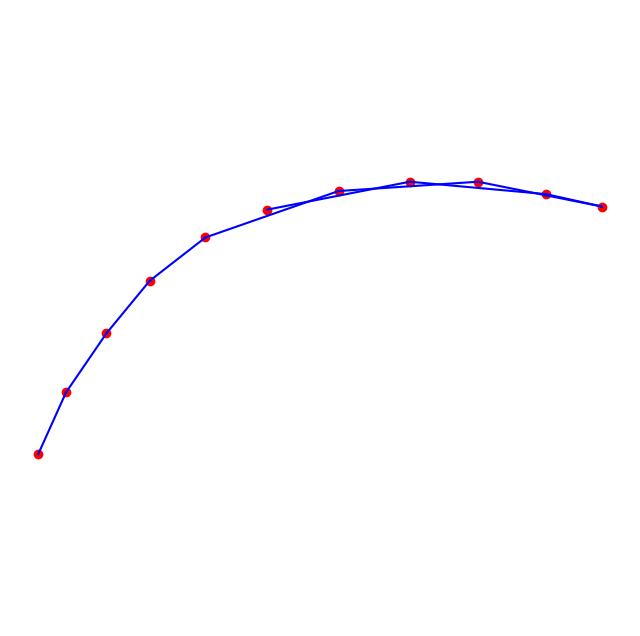